In [37]:
from utils import *
from wandb.keras import WandbCallback

In [31]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head1 = tf.keras.layers.Dense(128, kernel_initializer='zeros') #Necessary to initialize with zeros
    self.head2 = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    x1 = self.head1(bit_embedding)
    x2 = self.head2(x1)
    
    return x2

In [ ]:
'''x_train, y_train = create_image_data(dataset='hiv', split='train', img_spec='std')
print(x_train.shape, y_train.shape)

x_val, y_val = create_image_data(dataset='hiv', split='valid', img_spec='std')
print(x_val.shape, y_val.shape)'''

# HIV Dataset

In [5]:
#Directly loading since dataset has already been saved
x_train=np.load('hiv/hiv_images_std_resized_train.npy')
x_val=np.load('hiv/hiv_images_std_resized_val.npy')
x_train.shape, x_val.shape

((32757, 160, 160, 3), (4095, 160, 160, 3))

In [6]:
y_train = get_labels('hiv', 'train', 'std')
y_val = get_labels('hiv', 'valid', 'std')

hiv/hiv-featurized/smiles2img/std/index/train_dir/
Labels length:  32757
hiv/hiv-featurized/smiles2img/std/index/valid_dir/
Labels length:  4095


In [32]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((32757, 160, 160, 3), (32757, 1), (4095, 160, 160, 3), (4095, 1))

In [33]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0., 1.]), array([31705,  1052]))

In [41]:
momentum, BATCH_SIZE, lr, STEPS_PER_EPOCH, SCHEDULE_LENGTH,SCHEDULE_BOUNDARIES = init_params(x_train.shape[0], x_train.shape[1])
print(momentum, BATCH_SIZE, lr, STEPS_PER_EPOCH, SCHEDULE_LENGTH, SCHEDULE_BOUNDARIES)

0.9 512 0.003 10 10000.0 [3000, 6000, 9000]


In [42]:
config_defaults = dict(
    batch_size=BATCH_SIZE,
    momentum=momentum,
    learn_rate=lr
    )
wandb.init(project="summer-2020", id="BiT_HIV_Rx50_2_NO_Augmentation", config=config_defaults) 
config = wandb.config

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
ERROR:wandb.run_manager:Streaming file created twice in same run: /home/jupyter-rdutt2/Raman Data/wandb/run-20200716_192607-BiT_HIV_Rx50_2_NO_Augmentation/wandb-events.jsonl


In [43]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[config.learn_rate, config.learn_rate*0.1, 
                                                                           config.learn_rate*0.001, config.learn_rate*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=config.momentum)
opt2 = tf.keras.optimizers.SGD(learning_rate=config.learn_rate, momentum=config.momentum)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

aug = ImageDataGenerator()

In [44]:
module = get_module()
model = MyBiTModel(num_classes=2, module=module)


https://tfhub.dev/google/bit/m-r50x1/1


In [45]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [46]:
es = EarlyStopping(patience=10, verbose=1, monitor='val_loss')
wb = WandbCallback(monitor='val_loss', save_weights_only=False, save_model=True)
callbacks = [es, wb]

In [47]:
history = model.fit(aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
          epochs=50,
          verbose=1,
          steps_per_epoch = 10,
          validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/50


ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


10/10 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 1.0000

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


10/10 [==============================] - 132s 13s/step - loss: 0.6761 - accuracy: 1.0000 - val_loss: 0.6414 - val_accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 130s 13s/step - loss: 0.6029 - accuracy: 1.0000 - val_loss: 0.5544 - val_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 129s 13s/step - loss: 0.5184 - accuracy: 1.0000 - val_loss: 0.4736 - val_accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 127s 13s/step - loss: 0.4441 - accuracy: 1.0000 - val_loss: 0.4088 - val_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 128s 13s/step - loss: 0.3885 - accuracy: 1.0000 - val_loss: 0.3592 - val_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 129s 13s/step - loss: 0.3425 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 132s 13s/step - loss: 0.3094 - accuracy: 1.0000 - val_loss: 0.2921 - val_accuracy: 1.0000
Epoch 8/50
10/10 

In [50]:
model_dir = 'Models/HIV/'
model_name = 'BiT-HiV-Imbalanced-ResNet50x1-2'
tf.saved_model.save(model, model_dir+model_name)

INFO:tensorflow:Assets written to: Models/HIV/BiT-HiV-Imbalanced-ResNet50x1-2.h5/assets


INFO:tensorflow:Assets written to: Models/HIV/BiT-HiV-Imbalanced-ResNet50x1-2.h5/assets


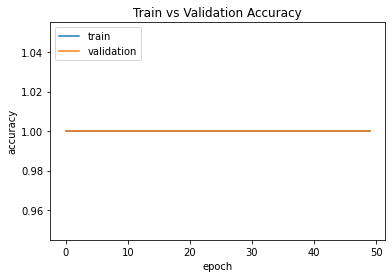

In [48]:
plot_acc(history)

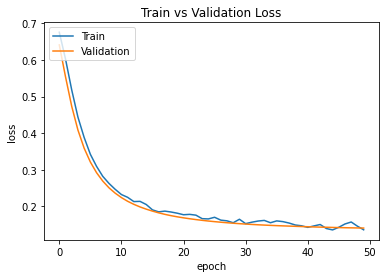

In [49]:
plot_loss(history)

# Testing

In [ ]:
x_test = create_image_data(dataset='hiv', split='test', img_spec='std')
print(x_test.shape)

In [ ]:
dataset='hiv'
img_spec='std'
split='test'
path=dataset+'/'+dataset+'-featurized/smiles2img/'+img_spec+'/index/'+split+'_dir/'
os.path.exists(path)

In [ ]:
'''x4=joblib.load(path+'shard-4-X.joblib')
x5=joblib.load(path+'shard-5-X.joblib')
images=np.concatenate((x4, x5))
images.shape'''

In [ ]:
y4=joblib.load(path+'shard-4-y.joblib')
y5=joblib.load(path+'shard-5-y.joblib')
labels=np.concatenate((y4, y5))
labels.shape

In [ ]:
path='Models/HIV/'
os.listdir(path)

In [ ]:
saved_module = hub.KerasLayer(path+'BiT-HiV-Imbalanced-ResNet50x1-1-full_model.h5/', trainable=True)

In [ ]:
_image = x_test[0]
image = np.expand_dims(_image, 0)
print(image.shape)
logits = saved_module(image)
len(logits)

In [ ]:
logits.shape